Kod colab:

In [5]:
import os
from traceback import print_tb

import scipy
import numpy as np


def function_3_1(m_3, m, sigma_3, sigma, f, g, x):
  x_3, timestamps = x[:,0:-1], x[:,-1]
  N_1_arr = []
  for count, t in enumerate(timestamps):
    tmp_n1 = scipy.stats.multivariate_normal.pdf(x_3[count,:], f(m_3, m, t), g(sigma_3, t)*scipy.stats.multivariate_normal.pdf(t, m, sigma))
    # print(tmp_n1)
    N_1_arr.append(tmp_n1)
  N_1 = np.stack(N_1_arr)
  # N_2 = scipy.stats.multivariate_normal.pdf(t, m, sigma)
  return N_1 #* N_2

# def function_3_c(m_3, m, sigma_3, sigma, f, g, x, t_0):
#   x_3, timestamps = x[:,0:-1], x[:,-1]
#   N_1_arr = []
#   # for t in timestamps:
#   for count, t in enumerate(timestamps):
#     tmp_n1 = scipy.stats.multivariate_normal.pdf(x_3[count,:], f(m_3, t_0), g(sigma_3, t_0)*scipy.stats.multivariate_normal.pdf(t_0, m, sigma))
#     # print(tmp_n1)
#     N_1_arr.append(tmp_n1)
#   N_1 = np.stack(N_1_arr)
#   # N_2 = scipy.stats.multivariate_normal.pdf(t, m, sigma)
#   return N_1 #* N_2

def function_3_c_approx(m_3, m, sigma_3, sigma, f, g, x, t0):
  x_3, timestamps = x[:,0:-1], x[:,-1]
  N_1_arr = []
  # for t in timestamps:
  for count, t in enumerate(timestamps):
    tmp_n1 = scipy.stats.multivariate_normal.pdf(x_3[count,:], f(m_3, m, t0), g(sigma_3, t0)*scipy.stats.multivariate_normal.pdf(t0, m, sigma))
    # print(tmp_n1)
    N_1_arr.append(tmp_n1)
  N_1 = np.stack(N_1_arr)
  # print(N_1)
  N_2 = 1#scipy.stats.multivariate_normal.pdf(t0, m, sigma)
  return N_1 * N_2


In [251]:
from traitlets import Unicode, HasTraits
import numpy as np
import pandas as pd

m_3 = np.array([1., 1.])
m = np.array([0.])
sigma_3 = np.array([[1,0], [0, 1]])
print(sigma_3.shape)
sigma = np.array([[1]])
x_3 = np.array([
    [0., 1., 2.],
    [1., 2., 2.],
    [3., 4., 2.]
])

f = lambda x, t, m: x + (m-t)**2
g = lambda x, t: x

import scipy.stats as stats
N = 10000
u1=stats.uniform(-4,8)
u2=stats.uniform(-4,8)
u3=stats.uniform(-4,8)

data1 = u1.rvs(size=N)
data2 = u2.rvs(size=N)
data3 = u3.rvs(size=N)

data = np.vstack( (data1,data2,data3) ).T
maxx = np.max(  function_3_1(m_3, m, sigma_3, sigma, f, g, data)  )
u4=stats.uniform(0,maxx) # ostatnia współrzędna musi być większa od zera

data4 = u4.rvs(size=N)

data = np.vstack( (data1,data2,data3,data4) ).T
data
# data[:,0:1]**2
# data[:,0:1].sum(1)**2


import pandas as pd

mask = data[:,3] < function_3_1(m_3, m, sigma_3, sigma, f, g, data[:,0:3] )
print(len(mask))
data_mask = data[mask,0:3]
df = pd.DataFrame(data_mask)



(2, 2)
10000


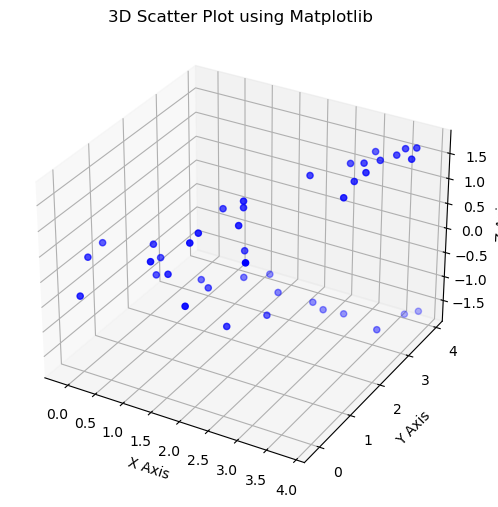

In [252]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[0], df[1], df[2], c='b', marker='o')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title("3D Scatter Plot using Matplotlib")

plt.show()


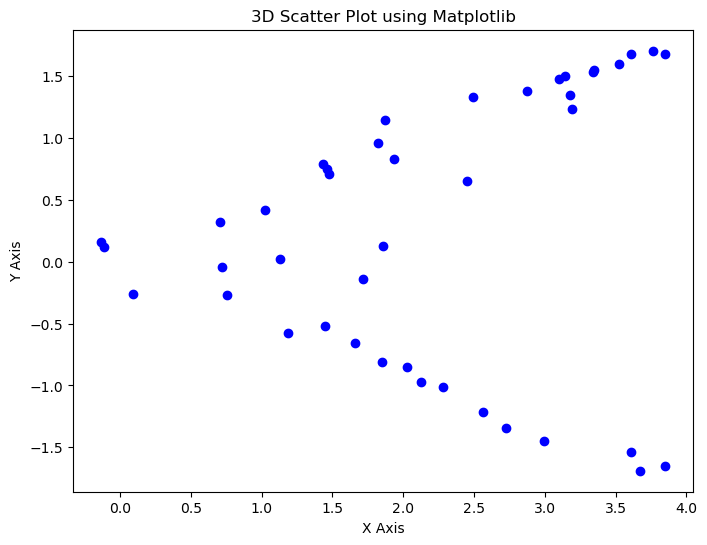

In [253]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(df[0], df[2], c='b', marker='o')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
plt.title("3D Scatter Plot using Matplotlib")

plt.show()


In [33]:
# def mahalanobis(means, samples, covs):
#     """
#     Calculates the mahalanobis distance between a batches of points and the original gaussian centre
#     """
#     delta = means - samples
#     delta = delta.unsqueeze(-1)
#
#     conv_inv = torch.inverse(covs)
#     mm_cov_delta = torch.bmm(conv_inv, delta)
#     m = torch.bmm(torch.transpose(delta, 1, 2), mm_cov_delta)
#
#     return torch.sqrt(m).squeeze(-1).squeeze(-1)

[]
tensor([[0.4239]])
tensor([[ 0.0933,  0.0000, -0.0985]], requires_grad=True)
torch.Size([10000, 2])


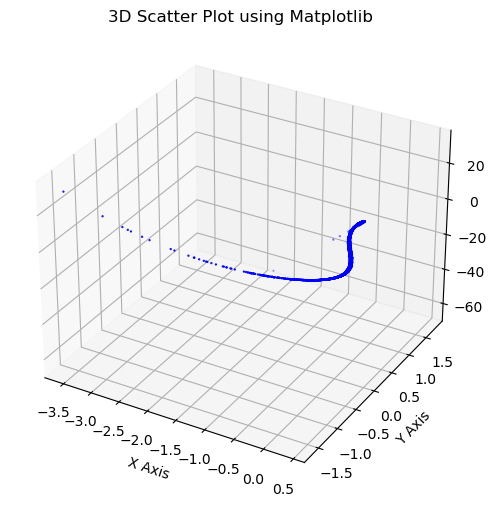

In [311]:
import torch
from vegas_utils import gaussian_model
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

with torch.no_grad():
    idx = 100
    ply_file = "files/bunny.ply"
    gaussians = gaussian_model.GaussianModel(0,7,0)
    gaussians.load_ply(ply_file)
    num_points_to_sample = 10000

    covariances_for_point = gaussians.get_covariance()[idx]

    covariance = torch.zeros(1, 2, 2)
    covariance[: ,0, 0] = covariances_for_point[0]  # (0, 0)
    covariance[:, 0, 1] = covariances_for_point[2]  # (0, 1)
    covariance[:, 1, 0] = covariances_for_point[2]  # (0, 1)
    covariance[:, 1, 1] = covariances_for_point[5]  # (1, 1)

    m = gaussians.get_m[idx].detach()
    sigma = gaussians.get_sigma[idx]

    print(sigma)


    t_dist = Normal(m, sigma)
    t_sample = t_dist.sample((num_points_to_sample,)).squeeze(-1)

    poly_weights = torch.chunk(gaussians._w1[idx], chunks=gaussians.polynomial_degree, dim=-1)
    center_gaussians = m - t_sample

    mean = gaussians.get_xyz[idx].unsqueeze(0)
    mean2d = mean[:, [0, -1]]
    mean2d_org = mean2d[:]
    print(mean)
    for i, poly_weight in enumerate(poly_weights):
        mean2d = mean2d + poly_weight * (center_gaussians ** (i + 1))

    numerator = t_dist.log_prob(t_sample).exp()
    denominator = t_dist.log_prob(m).exp()

    a = numerator / denominator

    # mean2d = mean2d.transpose(0, 1).squeeze(1).reshape(-1,2)

    means_repeated = torch.repeat_interleave(mean[:, [0,-1]], num_points_to_sample,dim=0)

    mean_s_given_t = means_repeated + mean2d
    print(mean_s_given_t.shape)

    covariances_repeated = torch.repeat_interleave(covariance, num_points_to_sample,dim=0)
    cov_s_given_t = covariances_repeated * a.reshape(-1,1,1)

    conditional_s_given_t = MultivariateNormal(mean_s_given_t, cov_s_given_t)
    sampled_points = conditional_s_given_t.sample()

    sampled_points = torch.cat((sampled_points[:, 0, None], t_sample.reshape(-1,1), sampled_points[:,1, None]), dim=1)
    # sampled_points = torch.cat((sampled_points[:, 0, None], sampled_points[:,1, None]), dim=1)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # ax = fig.add_subplot(111)
    #
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='b', marker='o', s=0.4)
    # ax.scatter(sampled_points[:, 0], sampled_points[:, -1], c='b', marker='o')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    plt.title("3D Scatter Plot using Matplotlib")

    plt.show()
    plt.close()

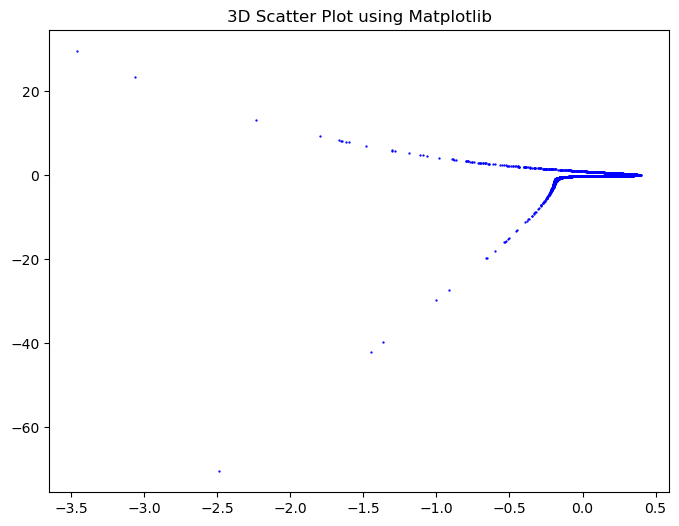

In [302]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#
ax.scatter(sampled_points[:, 0], sampled_points[:, -1], c='b', marker='o', s=0.4)
plt.title("3D Scatter Plot using Matplotlib")

plt.show()
plt.close()

In [275]:
# import scipy.stats as stats
#
# with torch.no_grad():
#     m_3 = mean2d_org[:].detach().squeeze(0)
#     sigma_3 = covariance[:].detach().squeeze(0)
#
#     f = lambda x, m, t: x + sum(poly_weight * ((m - t) ** (i + 1)) for i, poly_weight in enumerate(poly_weights))
#     g = lambda x, t: x
#
#     N = 10000
#     u1=stats.uniform(-3,3)
#     u2=stats.uniform(-3,3)
#     u3=stats.uniform(-3,3)
#
#     data1 = u1.rvs(size=N)
#     data2 = u2.rvs(size=N)
#     data3 = u3.rvs(size=N)
#
#     data = np.vstack( (data1,data2,data3) ).T
#     maxx = np.max(function_3_1(m_3, m, sigma_3, sigma, f, g, data))
#     u4=stats.uniform(0,1) # ostatnia współrzędna musi być w
#     # iększa od zera
#
#     data4 = u4.rvs(size=N)
#     data = np.vstack( (data1,data2,data3,data4) ).T
#     # data[:,0:1]**2
#     # data[:,0:1].sum(1)**2
#
#
#     import pandas as pd
#     print(function_3_1(m_3, m, sigma_3, sigma, f, g, data[:,0:3] ))
#     mask = data[:,3] < function_3_1(m_3, m, sigma_3, sigma, f, g, data[:,0:3] )
#     data_mask = data[mask, 0:3]
#     df = pd.DataFrame(data_mask)


[0. 0. 0. ... 0. 0. 0.]


In [312]:
# %matplotlib inline
#
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
#
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
#
# ax.scatter(df[0], df[1], df[2], c='b', marker='o', s=1)
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# plt.title("3D Scatter Plot using Matplotlib")
#
# plt.show()


In [277]:
# # m_3 = np.array([1., 1.])
# # m = np.array([0.])
# # sigma_3 = np.array([[1,0], [0, 1]])
# with torch.no_grad():
#     f = lambda x, t, m: x*(m-t)**2
#     g = lambda x, t: x
#
#     import scipy.stats as stats
#     N = 10000
#     u1=stats.uniform(-1,1)
#     u2=stats.uniform(-1,1)
#     u3=stats.uniform(-1,1)
#
#     data1 = u1.rvs(size=N)
#     data2 = u2.rvs(size=N)
#     data3 = u3.rvs(size=N)
#
#     data = np.vstack( (data1,data2,data3) ).T
#     print(m_3.shape, m.shape, sigma_3.shape, sigma.shape)
#     maxx = np.max(  function_3_1(m_3, m, sigma_3, sigma, f, g, data)  )
#     u4=stats.uniform(0,maxx) # ostatnia współrzędna musi być większa od zera
#
#     data4 = u4.rvs(size=N)
#
#     data = np.vstack( (data1,data2,data3,data4) ).T
#     data
#     # data[:,0:1]**2
#     # data[:,0:1].sum(1)**2
#
#
#     import pandas as pd
#
#     mask = data[:,3] < function_3_1(m_3, m, sigma_3, sigma, f, g, data[:,0:3] )
#     print(len(mask))
#     data_mask = data[mask,0:3]
#     # data_mask
#     df = pd.DataFrame(data_mask)
#     # df["text"] = np.round(dist.pdf(s),2)
#     # df["norm"] = np.round(np.linalg.norm( s, axis=1 ),2)
#
#     # import plotly.express as px
#     # df = px.data.iris()
#     # fig = px.scatter_3d(df, x=df.columns[0], y=df.columns[1], z=df.columns[2], opacity=0.7, title = "f(x) = x*t**2, g(x)=x")
#     # fig.show()
# df


torch.Size([2]) torch.Size([1]) torch.Size([2, 2]) torch.Size([1, 1])
10000


,0,1,2
0,-0.28483,-0.040751,-0.00432


tensor([[1.0189, 1.0189],
        [1.0088, 1.0088],
        [2.0258, 2.0258],
        ...,
        [1.5006, 1.5006],
        [1.0445, 1.0445],
        [1.9106, 1.9106]])


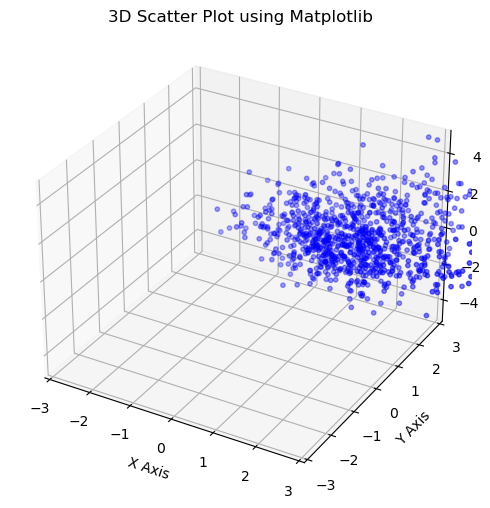

In [346]:
import torch
from vegas_utils import gaussian_model
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
num_points_to_sample = 1000

m_3 = torch.tensor([1., 1.]).unsqueeze(0)
m = torch.tensor([0.])
covariance = torch.tensor([[1,0], [0, 1]]).unsqueeze(0)
sigma = torch.tensor([[1]])

t_dist = Normal(m, sigma)
t_sample = t_dist.sample((num_points_to_sample,)).squeeze(-1)

center_gaussians = m - t_sample
mean2d = m_3[:]
mean2d = mean2d +  center_gaussians ** 2
print(mean2d)

numerator = t_dist.log_prob(t_sample).exp()
denominator = t_dist.log_prob(m).exp()
a = numerator / denominator

# mean2d = mean2d.transpose(0, 1).squeeze(1).reshape(-1,2)

means_repeated = torch.repeat_interleave(m_3, num_points_to_sample,dim=0)

mean_s_given_t = means_repeated + mean2d

covariances_repeated = torch.repeat_interleave(covariance, num_points_to_sample,dim=0)
cov_s_given_t = covariances_repeated * 1.

conditional_s_given_t = MultivariateNormal(mean_s_given_t, cov_s_given_t)
sampled_points = conditional_s_given_t.sample()

sampled_points = torch.cat((sampled_points[:, 0, None], t_sample.reshape(-1,1), sampled_points[:,1, None]), dim=1)
# sampled_points = torch.cat((sampled_points[:, 0, None], sampled_points[:,1, None]), dim=1)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)
#
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='b', marker='o', s=10)
# ax.scatter(sampled_points[:, 0], sampled_points[:, -1], c='b', marker='o')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
plt.xlim(-3,3)
plt.ylim(-3,3)
ax.set_zlim(-5,5)
plt.title("3D Scatter Plot using Matplotlib")

plt.show()
plt.close()

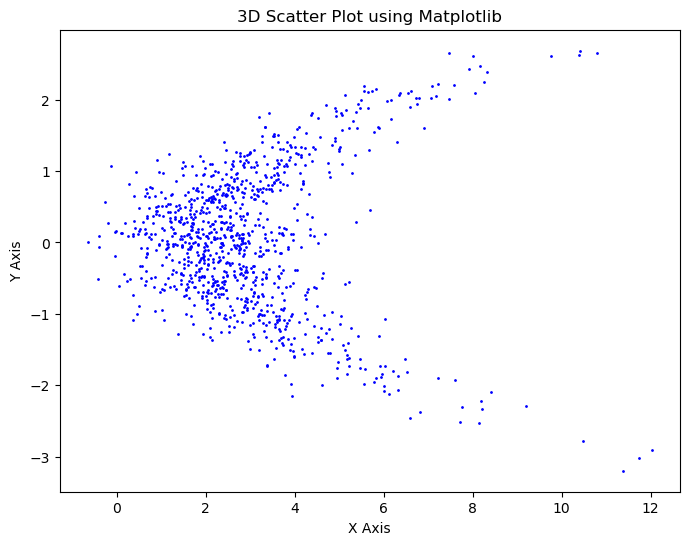

In [347]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], c='b', marker='o', s=1)
# ax.scatter(sampled_points[:, 0], sampled_points[:, -1], c='b', marker='o')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis
plt.title("3D Scatter Plot using Matplotlib")

plt.show()
plt.close()